# Website Visitors Conversion Rate Optimization (CRO)
    Ruixie Fang
    
### Goal

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.

The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and ﬁx it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve re]enue.

This challenge is signiﬁcantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science takehome challenges.

### Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

   - Predict conversion rate

   - Come up with recommendations for the product team and the marketing team to improve conversion rate.

### Columns:

- country : user country based on the IP address 
- age : user age. Self-reported at sign-in step 
- new_user : whether the user created the account during this session or had already an account and simply came back to the site 
- source : marketing channel source:
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser 
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [116]:
# Analysis imports
import numpy as np
import pandas as pd

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML imports
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix

# Miscellaneous imports
import warnings
warnings.simplefilter('ignore')


## Import data and Basic Descriptive Analysis
- Variable Types / Missing value/ Outliers.

In [85]:
df = pd.read_csv("conversion_project.csv")
df.sample(10)

,country,age,new_user,source,total_pages_visited,converted
300437,US,21,1,Ads,4,0
24607,China,17,1,Seo,4,0
304866,US,24,0,Seo,1,0
83101,China,36,0,Seo,3,0
183123,US,35,1,Seo,3,0
188796,US,39,0,Seo,2,0
77045,US,29,0,Ads,7,0
89235,UK,24,0,Seo,21,1
130261,US,45,0,Direct,5,0
137815,China,44,1,Ads,4,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [62]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     58	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


**Categorical**: country, converted, new_user, source.   \
**Continous**: Age,total_pages_visited. \
Two features are strings (object), others are numeric.

In [42]:
#Check Missing values
print('Columns with null values:\n', df.isnull().sum())

Columns with null values:
 country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64


In [43]:
numeric_df=df._get_numeric_data()
numeric_df.head()

,age,new_user,total_pages_visited,converted
0,25,1,1,0
1,23,1,5,0
2,28,1,4,0
3,39,1,5,0
4,30,1,6,0


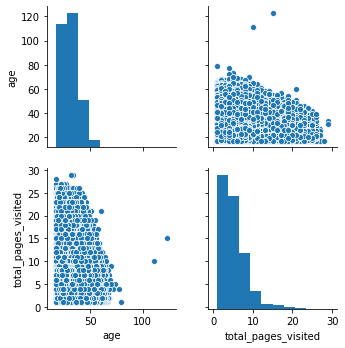

In [44]:
#Check outliers based on age and total_pages_visited
df_num=df[["age", "total_pages_visited"]]
#use scatterplot and histogram to find outliers
sns.pairplot(df_num)

Typically, age should be below 100. These two obvious point(>100) can be identified as outliers and removed.

In [45]:
df[df['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [46]:
# Remove outliers
df = df[df.age < 100]

In [47]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


**The distribution of numerical feature values across 316200 samples:**
- Most visitors' age are around 22-38.
- 69% of visitors are new users. 
- Total_pages_visited per visitor is around 4-5.
- The conversion rate=3.23% indicates that visitors are hard to convert into customers.


## Exploratory Data Analysis
- Feature Analysis : Country / User Type / Total Pages visited / Sources /Ages

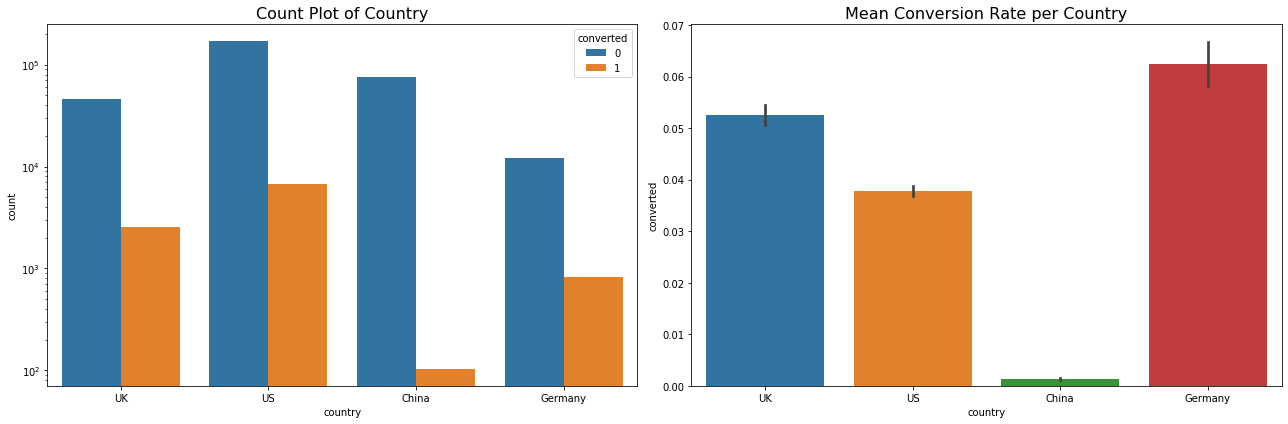

In [48]:
# Visualization of different countries
grouped = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on country:**
- The overall rate of Conversion = 0 is greater than conversion = 1.
- Most visitors are from US.
- German has less visitors but highest conversion rate.
- China has 2nd rank of visitors number but with extreme low conversion rate. 

It might be a reason that affect visitors. Website language for product description may be all English. \
Since China is a large population country. Improving Chinese visitors' user experience, it might be a good strategy to increase conversion rate.

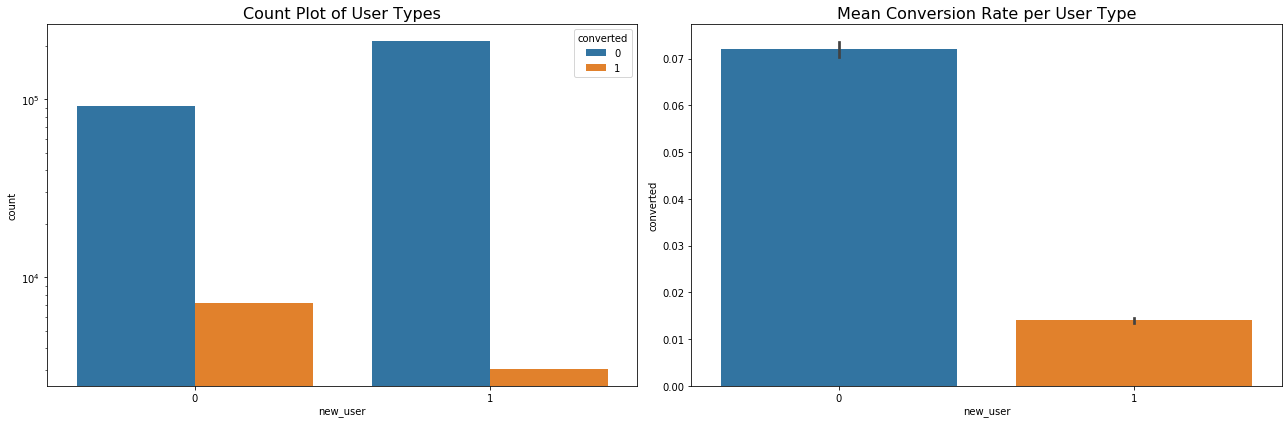

In [33]:
# Visualization of different user types
grouped = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on user type:**  \
The mean conversion rate of old-users is almost 75.7% than that of new-users. 

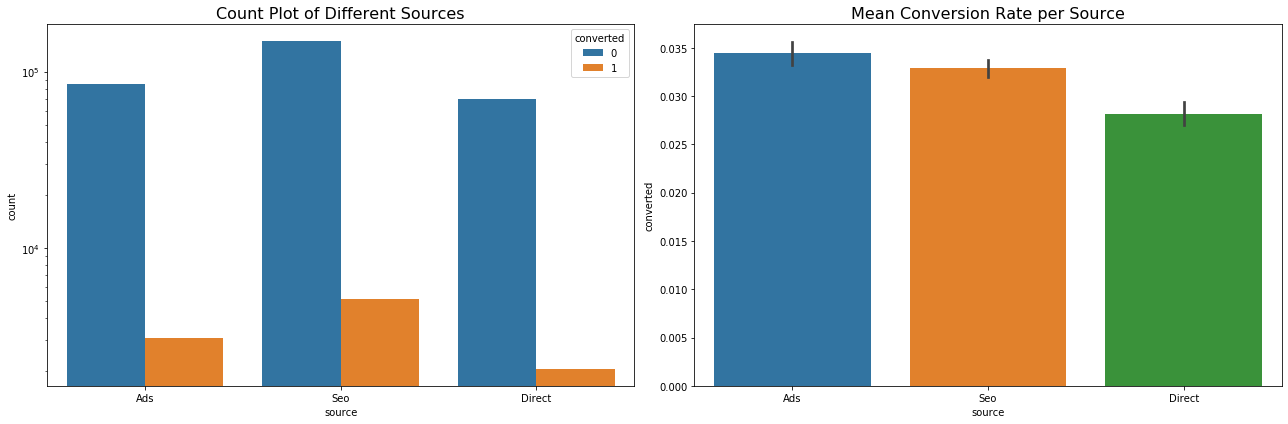

In [37]:
# Visualization of different sources
grouped = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on sources:**   

    Ads: came to the site by clicking on an advertisement
    Seo: came to the site by clicking on search results
    Direct: came to the site by directly typing the URL on the browser  
- The advertisement can be a powerful campaign to attract visitors.
- Visitors from search source has the highest conversion rate. They have more motivation to purchase since they have a purpose in knowing about the product.

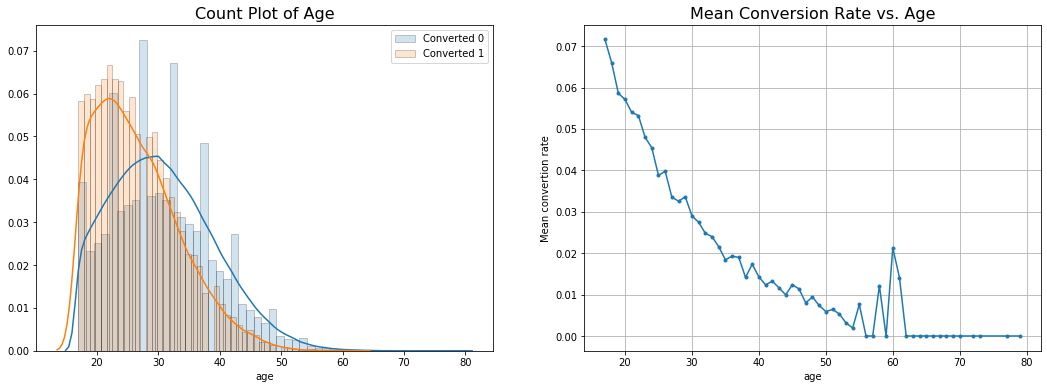

In [49]:
# Visualization of different age
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

**Assumption based on age:**
- Most visitors' age are around 22-38 and all visitors age>65 are not convert into customer. 
- Negative relasionship between age and conversion rate. Normally younger people have higher purchase demand than older person.
- Especially visitors' age from 18-32 has higher conversion rate. The reason might be that the product suits younger people's need more.

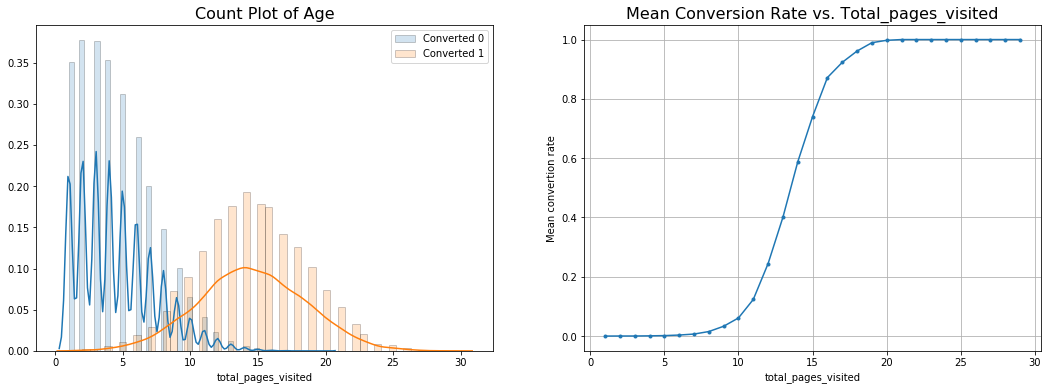

In [67]:
# Visualization of total_pages_visited
grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

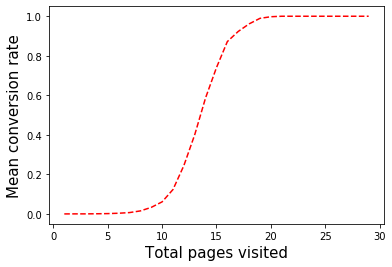

In [36]:
# Visualization of total_pages_visited
#page_cr = df.groupby("total_pages_visited")["converted"].mean()
#plt.plot(page_cr.index,page_cr.values,"r--")
#plt.xlabel("Total pages visited", fontsize=15)
#plt.ylabel("Mean conversion rate", fontsize=15)
#plt.show()

There is a positive regression relationship between total_pages_visited and converted mean. The visitor with greater visites pages has higher potential to convert into customer.

## Machine Learning
Preprocessed data with different methods:
- Modeling: Random Forest
    - H2o https://towardsdatascience.com/democratising-machine-learning-with-h2o-7f2f79e10e3f
    - scikit-learn + Feature Engneering(One-hot-encoding/dummy coding,Normalization) 
    - cross validation/ 10-fold validation
  

### H2o + Stratified Sampling (7:3)

In [ ]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

In [53]:
dfh=df.copy()
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(dfh)
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [55]:
#Split into 70% training and 30% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [56]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


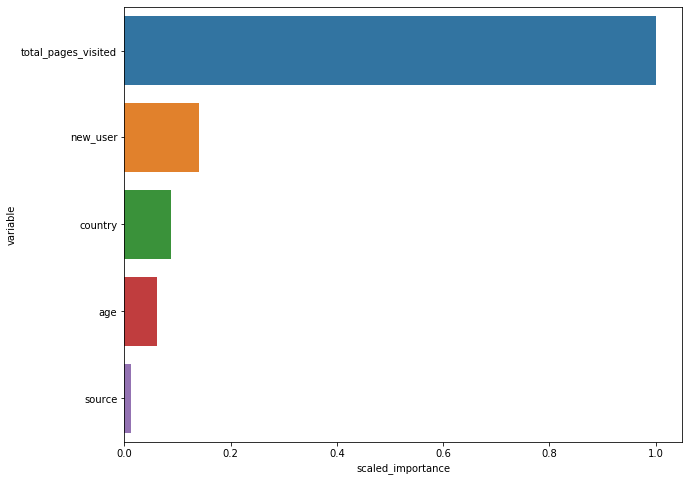

In [57]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [58]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [59]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91800
           1       0.84      0.63      0.72      3059

    accuracy                           0.98     94859
   macro avg       0.92      0.81      0.86     94859
weighted avg       0.98      0.98      0.98     94859



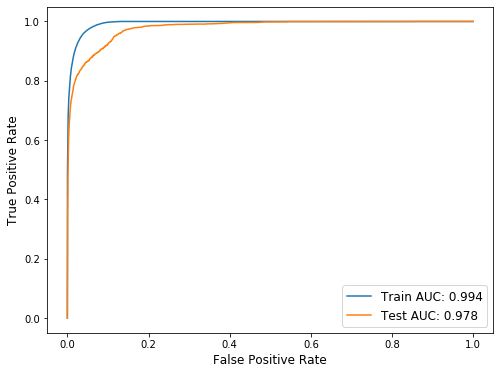

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

# -------------------------------- 97.8% ------------------------------------- 

# Other method practice.

### Feature Engineering + scikit learn random forest +cross validation/10-fold validation

In [91]:
#Convert the categorical values to ordinal.
#That categorical data is defined as variables with a finite set of label values. 
#That most machine learning algorithms require numerical input and output variables. 
#That an integer and one hot encoding is used to convert categorical data to integer data.

#one-hot-coding
#dfc=df.copy()
#dfc['country'] = dfc['country'].map({"China": 1, "Germany": 2, "UK": 3, "US": 4}).astype(int)
#dfc['source'] = dfc['source'].map( {'Ads': 0, 'Direct': 1, 'Seo': 2} ).astype(int)
#dfc.sample(10)

#dummy coding
# Create dummy variables for country values
dfd=df.copy()
country_dummies = pd.get_dummies(dfd.country, prefix='country')
dfd = pd.concat([dfd, country_dummies], axis=1)
# Create dummy variables for source values
source_dummies = pd.get_dummies(dfd.source, prefix='source')
dfd = pd.concat([dfd, source_dummies], axis=1)
dfd.drop(["country", "source"], axis=1, inplace=True)
dfd.sample(10)

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
35348,31,0,3,0,0,0,0,1,0,0,1
126957,31,0,6,0,0,0,0,1,0,1,0
185004,18,1,1,0,0,0,1,0,1,0,0
207062,21,1,4,0,0,0,0,1,1,0,0
289357,38,1,5,0,0,0,1,0,0,0,1
294592,19,1,10,0,0,0,0,1,0,0,1
193040,35,0,7,0,1,0,0,0,0,0,1
225535,20,1,3,0,0,0,0,1,0,0,1
308586,20,1,10,0,1,0,0,0,1,0,0
183150,21,1,8,0,0,1,0,0,0,1,0


In [96]:
#Normalization (Here used min-max normalization)
# Min-max normalization: Guarantees all features will have the exact same scale but does not handle outliers well. 
# Z-score normalization: Handles outliers, but does not produce normalized data with the exact same scale.
dfd_normalize = dfd[["age", "total_pages_visited"]].copy()
m = dfd_normalize.values
min_max_scaler = preprocessing.MinMaxScaler()
m_scale = min_max_scaler.fit_transform(m)
m_normalize = pd.DataFrame(m_scale, columns = dfd_normalize.columns)
dfd[["age", "total_pages_visited"]]=m_normalize
dfd = dfd[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "age", 
            "new_user", 
            "total_pages_visited", 
            "converted"]]
dfd.sample(10)

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,age,new_user,total_pages_visited,converted
239882,0,0,0,1,0,0,1,0.179245,1,0.250000,0
176307,0,1,0,0,0,1,0,0.320755,1,0.071429,0
133877,1,0,0,0,1,0,0,0.141509,1,0.178571,0
159406,0,1,0,0,1,0,0,0.179245,1,0.250000,0
27717,0,0,0,1,0,0,1,0.179245,1,0.285714,0
228607,1,0,0,0,0,0,1,0.056604,1,0.000000,0
303396,0,0,0,1,0,1,0,0.066038,0,0.214286,0
41950,1,0,0,0,1,0,0,0.103774,1,0.107143,0
116327,1,0,0,0,0,0,1,0.216981,0,0.000000,0
277559,0,0,1,0,0,1,0,0.047170,1,0.428571,1


#### Cross Validation
Many a times, the data is imbalanced, i.e there may be a high number of class1 instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset.

An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, we can achieve a generalised model.

In [127]:
#cross validation
trains,tests=train_test_split(dfd,test_size=0.3,random_state=0,stratify=dfd['converted'])
train_X=trains[trains.columns[:-1]]
train_Y=trains[trains.columns[-1:]]
test_X=tests[tests.columns[:-1]]
test_Y=tests[tests.columns[-1:]]
rf=RandomForestClassifier(n_estimators=200)
rf.fit(train_X,train_Y)
rf.score(test_X,test_Y)

0.9846194391735189

In [128]:
# 10-fold validation
X=dfd[dfd.columns[:-1]]
Y=dfd['converted']
kfold = KFold(n_splits=10, random_state=22)
cv_result = cross_val_score(RandomForestClassifier(n_estimators=200),X,Y, cv = kfold,scoring = "accuracy")
cv_result.mean()

0.9846932321315623

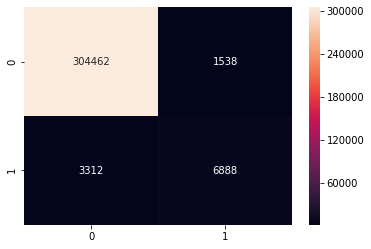

In [130]:
y_pred= cross_val_predict(RandomForestClassifier(n_estimators=200),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),annot=True,fmt='2.0f')

In [141]:
varimp=pd.Series(rf.feature_importances_,X.columns).sort_values(ascending=False)
varimp

total_pages_visited    0.806009
age                    0.113433
new_user               0.040589
country_China          0.021587
country_UK             0.003902
country_US             0.003734
country_Germany        0.002778
source_Seo             0.002778
source_Ads             0.002604
source_Direct          0.002584
dtype: float64

# ----------------------------------98.5%-------------------------------------

### feature selection and model improvement

Dropped total_pages_visited: This attribute highly affects the output target. Yet, the total_pages_visited is not known before a user visit a website. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [143]:
df_nopage=dfd.drop(columns=['total_pages_visited'])
df_nopage.head()

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,age,new_user,converted
0,1,0,0,0,1,0,0,0.075472,1,0
1,0,1,0,0,0,0,1,0.056604,1,0
2,0,1,0,0,0,0,1,0.103774,1,0
3,0,0,0,1,0,0,1,0.207547,1,0
4,0,1,0,0,0,0,1,0.122642,1,0


In [145]:
trains2,tests2=train_test_split(df_nopage,test_size=0.3,random_state=0,stratify=df_nopage['converted'])
train_X2=trains2[trains2.columns[:-1]]
train_Y2=trains2[trains2.columns[-1:]]
test_X2=tests2[tests2.columns[:-1]]
test_Y2=tests2[tests2.columns[-1:]]
rf2=RandomForestClassifier(n_estimators=200)
rf2.fit(train_X2,train_Y2)
rf2.score(test_X2,test_Y2)

0.9676681425258276

In [146]:
X2=df_nopage[df_nopage.columns[:-1]]
varimp_nopages=pd.Series(rf2.feature_importances_,X2.columns).sort_values(ascending=False)
varimp_nopages

new_user           0.411470
age                0.324592
country_China      0.153980
country_US         0.036132
country_UK         0.030193
country_Germany    0.023774
source_Direct      0.007989
source_Ads         0.007010
source_Seo         0.004860
dtype: float64

# ----------------------------------96.8%-------------------------------------

## Results
Here I list the main insights gleaned from my analysis and some associated recommendations.

- **Chinese users are hard to convert.**\
This could be just due to translation or cultural issues. Either way, considering how many potential users are in China I'd recommend the UX department take a look at ways to improve it.
- **German users are relatively easy to convert.**\
Something is going very right with German users and so a little more focus on these users could have a large effect! This could be something for both UX and marketing to look into.
- **Users with an older account are more likely to convert than users with newer accounts.**\
Since they're already in the system, perhaps some targeted emails with offers to bring them back to the site could better capture their conversion potential.
- **Young people are much more likely to convert than older people.**\
UX department may want to look into why people 30+ perform so poorly.
- **Existing marketing channels do not have a significant effect one way or the other.**\
Considering that the site does well with younger users, development of new marketing channels should be done specifically so that they are aimed at reaching younger people.

If a user has visited many pages but hasn't yet converted, they very likely could have a high purchase intent. Perhaps such users could be sent targeted email offers or reminders.